In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
import pickle
import time

import sys
sys.stdout = open('output_of_LR_tfidf.txt','a')

stopwords = stopwords.words('english')

#### Load data

In [4]:
X = np.load('../data/X_token.npy', allow_pickle=True)
y = np.load('../data/y_binarized.npy', allow_pickle=True) 

#word embeddings using tf-idf
tf_idf_vect = TfidfVectorizer(stop_words=None)
tf_idf_vect.fit(X)
X_final_tf_idf = tf_idf_vect.transform(X)
tfidf_feat = tf_idf_vect.get_feature_names()

X_train, X_test, y_train, y_test = train_test_split(X_final_tf_idf, y, test_size=0.4, random_state=1)
# validation set
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)


/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Tags for plotting

In [5]:
tags = np.load('../data/y_tags.npy', allow_pickle=True)

# Logistic regression

LR multiple binary classifiers

In [6]:
def train_lr(class_wt = 0, name=None):
    LR_model_list = []
    for i in range(y_train.shape[1]):
        sample_y_train = y_train[:, i]
        LR_clf_single = LogisticRegression(n_jobs=-1, solver='newton-cg', class_weight=class_wt, C=0.01)
        LR_clf_single.fit(X_train, sample_y_train)
        LR_model_list.append(LR_clf_single)
    with open(name, 'wb') as f:
        pickle.dump(LR_model_list, f)
    return LR_model_list

    

In [7]:
def pred_lr(model, x_data):
    return model.predict(x_data)

In [8]:
def calc_scores(name, LR_model_list):
    precision_tr = []
    precision_v = []
    recall_tr = []
    recall_v = []
    f1_tr = []
    f1_v = []
    accu_tr = []
    accu_v = []
    
    for i in range(len(LR_model_list)):
        y_pred_tr = pred_lr(LR_model_list[i], X_train)
        y_pred_v = pred_lr(LR_model_list[i] ,(X_val))

        precision_tr.append(precision_score(y_pred=y_pred_tr, y_true=y_train[:,i]))
        precision_v.append(precision_score(y_pred=y_pred_v, y_true=y_val[:,i]))

        recall_tr.append(recall_score(y_pred=y_pred_tr, y_true=y_train[:,i]))
        recall_v.append(recall_score(y_pred=y_pred_v, y_true=y_val[:,i]))

        f1_tr.append(f1_score(y_pred=y_pred_tr, y_true=y_train[:,i]))
        f1_v.append(f1_score(y_pred=y_pred_v, y_true=y_val[:,i]))

        accu_tr.append(accuracy_score(y_pred=y_pred_tr, y_true=y_train[:,i]))
        accu_v.append(accuracy_score(y_pred=y_pred_v, y_true=y_val[:,i]))

    with open("../results/precision_C_tr_"+name+".txt", "w") as output:
        output.write(str(y_pred_tr))
    with open("../results/precision_C_v_"+name+".txt", "w") as output:
        output.write(str(y_pred_v))
    with open("../results/recall_C_tr"+name+".txt", "w") as output:
        output.write(str(recall_tr))
    with open("../results/recall_C_v"+name+".txt", "w") as output:
        output.write(str(recall_v))
    with open("../results/f1_C_tr"+name+".txt", "w") as output:
        output.write(str(f1_tr))
    with open("../results/f1_C_v"+name+".txt", "w") as output:
        output.write(str(f1_v))
    with open("../results/accu_C_tr"+name+".txt", "w") as output:
        output.write(str(accu_tr))
    with open("../results/accu_C_v"+name+".txt", "w") as output:
        output.write(str(accu_v))
    
    return precision_tr, precision_v, recall_tr, recall_v, f1_tr, f1_v, accu_tr, accu_v

In [9]:
def plotting_metrics(metric_list, name, tags=tags):
    disp_df = pd.DataFrame(
        {'tags': tags,
        'prec': metric_list
        })
    disp_df = disp_df.sort_values(by = 'prec' , ascending=False)
    plt.xticks(fontsize=10)
    plt.figure(figsize=(300, 200), dpi=200)
    plt.bar(disp_df['tags'], disp_df['prec'])
    plt.savefig(name)

LR for weight=None

In [14]:
start_time = time.time()
LR_model_list_large_alpha = train_lr(class_wt = None, name='../models/LR_none_wt_model_list_tfidf.pkl')
print('Execution time for log reg with None class weight, for tf-idf embeddings_newton',time.time()-start_time)


LR for C=0.1

In [13]:
start_time = time.time()
LR_model_list_med_C = train_lr(class_wt = 'balanced', name='../models/LR_bal_wt_model_list_tfidf.pkl')
print('Execution time for log reg with balanced class weight, for tf-idf embeddings',time.time()-start_time)


LR for C=0.01

In [16]:
start_time = time.time()
LR_model_list_small_C = train_lr(class_wt={0:1, 1:10},name='../models/LR_self_wt_model_list_tfidf.pkl')
print('Execution time for LR with 1:10 wt , for tf-idf embeddings',time.time()-start_time)


Trained models can be loaded using the following lines

In [10]:
LR_model_list_large_C = pickle.load(open('../models/LR_large_C_model_list_tfidf.pkl', 'rb'))
LR_model_list_med_C = pickle.load(open('../models/LR_bal_wt_model_list_tfidf.pkl', 'rb'))
LR_model_list_small_C = pickle.load(open('../models/LR_small_C_model_list_tfidf.pkl', 'rb'))

Calculating evaluation metrics for LR with C = 1

In [17]:
precision_large_C_tr, precision_large_C_v,recall_large_C_tr,recall_large_C_v, f1_large_C_tr, f1_large_C_v, accu_large_C_tr, accu_large_C_v = calc_scores('large_C',LR_model_list_large_alpha)
f1_mean_large_C_tr = np.mean(f1_large_C_tr)
accu_mean_large_C_tr = np.mean(accu_large_C_tr)
print("F1 mean for large C, LR, tfidf: ", f1_mean_large_C_tr)
print("accuracy mean for large C, LR, tfidf: ", accu_mean_large_C_tr)

/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages

Calculating evaluation metrics for LR with C = 0.1

In [19]:
precision_med_C_tr, precision_med_C_v,recall_med_C_tr,recall_med_C_v, f1_med_C_tr, f1_med_C_v, accu_med_C_tr, accu_med_C_v = calc_scores('med_C',LR_model_list_med_C)
f1_mean_med_C_v = np.mean(f1_med_C_v)
accu_mean_med_C_v = np.mean(accu_med_C_v)
print("F1 mean for med C, LR, tfidf: ", f1_mean_med_C_v)
print("accuracy mean for med C, LR, tfidf ", accu_mean_med_C_v)

Calculating evaluation metrics for LR with C = 0.01

In [18]:
precision_small_C_tr, precision_small_C_v,recall_small_C_tr,recall_small_C_v, f1_small_C_tr, f1_small_C_v, accu_small_C_tr, accu_small_C_v = calc_scores('self',LR_model_list_small_C)
f1_mean_small_C_v = np.mean(f1_small_C_v)
accu_mean_small_C_v = np.mean(accu_small_C_v)
print("F1 mean for small C, LR, tfidf ", f1_mean_small_C_v)
print("accuracy mean for small C, LR, tfidf ", accu_mean_small_C_v)

/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages

Confusion matrix for the best model:

In [14]:
precision_test = []
recall_test = []
f1_test = []
accu_test = []
for i in range(len(LR_model_list_large_C)):
    y_pred_test = pred_lr(LR_model_list_large_C[i],X_test)
    precision_test.append(precision_score(y_pred=y_pred_test, y_true=y_test[:,i]))
    recall_test.append(recall_score(y_pred=y_pred_test, y_true=y_test[:,i]))
    f1_test.append(f1_score(y_pred=y_pred_test, y_true=y_test[:,i]))
    accu_test.append(accuracy_score(y_pred=y_pred_test, y_true=y_test[:,i]))
print("accuracy for test: ", np.mean(accu_test))
print("f1_test for test: ", np.mean(f1_test))

/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages

In [47]:
precision_test = []
recall_test = []
f1_test = []
accu_test = []
for i in range(len(LR_model_list_med_C)):
    y_pred_test = pred_lr(LR_model_list_med_C[i],X_test)
    precision_test.append(precision_score(y_pred=y_pred_test, y_true=y_test[:,i]))
    recall_test.append(recall_score(y_pred=y_pred_test, y_true=y_test[:,i]))
    f1_test.append(f1_score(y_pred=y_pred_test, y_true=y_test[:,i]))
    accu_test.append(accuracy_score(y_pred=y_pred_test, y_true=y_test[:,i]))
print("accuracy for test: ", np.mean(accu_test))
print("f1_test for test: ", np.mean(f1_test))

In [48]:
print("Minimum accuracy: ", min(accu_test))
print("Tag: ",tags[np.argmin(accu_test)])


In [49]:
print("Minimum accuracy: ", max(accu_test))
print("Tag: ",tags[np.argmax(accu_test)])

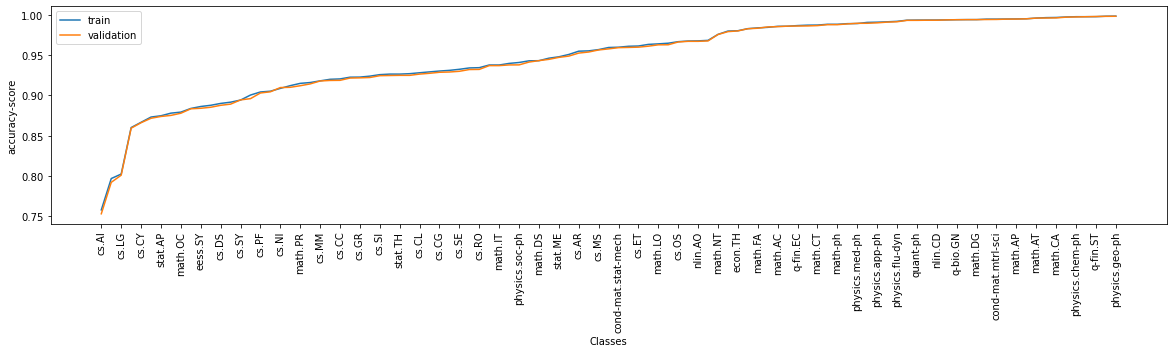

In [20]:
plt.close("all")
fig, ax = plt.subplots(figsize = (20, 4))
sorted_f1 = np.sort(accu_med_C_tr)
new_tags = tags[np.argsort(accu_med_C_v)]
idx = np.arange(len(new_tags))
width = 0.5
ax.plot(sorted(accu_med_C_tr))
ax.plot(sorted(accu_med_C_v))

xticks_idx = idx[::2]

ax.set_xticks(xticks_idx)
ax.set_xticklabels([new_tags[x] for x in xticks_idx], rotation=90)
ax.set_ylabel("accuracy-score")
ax.set_xlabel("Classes")
ax.legend(['train', 'validation'])
#plt.yscale("log")
plt.show()
fig.savefig("logreg_tf-plot.pdf", bbox_inches="tight")

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay
idx_good = np.where(tags=='cs.LG')[0][0]
idx_avg = np.where(tags=='cs.NE')[0][0]
idx_bad = np.where(tags=='cs.NA')[0][0]
print(idx_avg)
y_pred_v_good = LR_model_list_med_C[idx_good].predict(X_test)
y_pred_v_avg = LR_model_list_med_C[idx_avg].predict(X_test)
y_pred_v_bad = LR_model_list_med_C[idx_bad].predict(X_test)

m_good = confusion_matrix(y_pred=y_pred_v_good, y_true=y_test[:,idx_good])
m_avg = confusion_matrix(y_pred=y_pred_v_avg, y_true=y_test[:,idx_avg])
m_bad = confusion_matrix(y_pred=y_pred_v_bad, y_true=y_test[:,idx_bad])


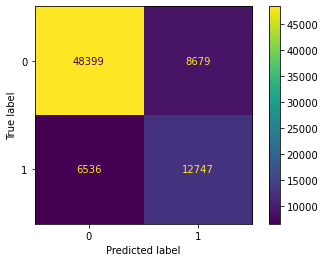

In [51]:
plt_good = ConfusionMatrixDisplay(m_good).plot()

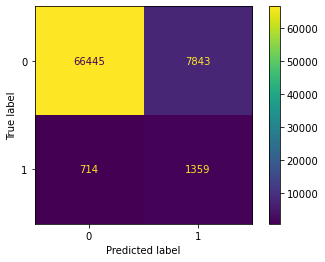

In [52]:
plt_avg = ConfusionMatrixDisplay(m_avg).plot()

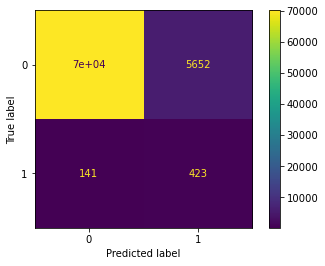

In [53]:
plt_bad = ConfusionMatrixDisplay(m_bad).plot()

In [ ]:
# plotting_metrics(recall_small_C_v, './results/recall_small_C_v.png')
# plotting_metrics(f1_small_C_v, './results/f1_small_C_v.png')
# plotting_metrics(precision_small_C_v, './results/precision_small_C_v.png')